- Reference: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [1]:
import sys
print(sys.version)

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
import numpy as np
import os
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import scipy.stats as scs

from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.pipeline import make_pipeline, make_union
from sklearn.model_selection import GridSearchCV

In [2]:
# multivariate output stacked lstm example
from numpy import array, hstack
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import  tensorflow as tf
from src.ml_helpers.make_ml_dataset import *
from src.ml_helpers.split_ml_dataset import *
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy_utils import create_database, database_exists, drop_database

from keras.regularizers import L1L2
tf.compat.v1.random.set_random_seed(1234)

from keras.optimizers import SGD

Using TensorFlow backend.


In [3]:
import jetson_configs as jcfg

In [4]:
split_date     = jcfg.train_test_split
current_month  = jcfg.current_month

admin_level = jcfg.admin_level
horizon     = jcfg.horizon #1
fpath       = f'{admin_level}_lag{horizon}'

In [5]:
expname = "_50"

# Configure connection

In [6]:
#We supply our credentials and point to the database we're trying to connect to and
host     = jcfg.sql_host
user     = jcfg.sql_user
password = jcfg.sql_password
database = "jetson"

engine = create_engine(f'postgresql://{user}:{password}@{host}/{database}') 

In [7]:
# Load the SQL_magic extension and configure the connection
%reload_ext sql_magic
%config SQL.conn_name = 'engine'

# Helper functions

In [8]:
def normalize(df, split_date):
    train_mean = df.loc[:pd.to_datetime(split_date)].mean()
    train_std  = df.loc[:pd.to_datetime(split_date)].std()
    return train_mean, train_std, (df - train_mean) / train_std

def denormalize(df, split_date, train_mean, train_std):
    return (df * train_std) + train_mean

In [9]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    ''' 
    sequences = an n x (k+1) array of training points
    
    Returns an n x k x n_steps array of training points, and an n x 1 array of test points
    '''
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
            
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


# Import data

In [10]:
learn_df = make_ml_features(current_month, horizon, admin_level, sql_engine=engine)
learn_df.sort_index(inplace=True)

### Split the columns into input and target columns and set the target variable
learn_df['true'] = learn_df['arrivals'].copy()

y_col =  'true'    
X_cols = [i for i in learn_df.columns if i != y_col]   

learn_df = fill_missing_values(learn_df, X_cols)
learn_df = fill_missing_values(learn_df, y_col) # OPTIONAL: fill the y values

#learn_df = shift_input_features(learn_df, X_cols, y_col, horizon, current_month, admin_unit = 'region')

learn_df.dropna(subset=X_cols, inplace=True, how='any')

regions = learn_df.index.get_level_values('region').unique()
learn_df.index.get_level_values('date')

#X_train_scaled, y_train, X_scaled, X,y, train_months, test_months = split_ml_dataset(learn_df, split_date, y_col = y_col, X_cols = X_cols)

Dropped entirely missing columns:  []
Dropped duplicate columns:  ['miss_incidents', 'miss_malaria_cases', 'miss_measles_cases', 'miss_vegetation_cover_ndvi']


DatetimeIndex(['2011-01-01', '2011-01-01', '2011-01-01', '2011-01-01',
               '2011-01-01', '2011-01-01', '2011-01-01', '2011-01-01',
               '2011-01-01', '2011-01-01',
               ...
               '2020-08-01', '2020-08-01', '2020-08-01', '2020-08-01',
               '2020-08-01', '2020-08-01', '2020-08-01', '2020-08-01',
               '2020-08-01', '2020-08-01'],
              dtype='datetime64[ns]', name='date', length=2088, freq=None)

## Set up for learning

In [11]:
# Choose a number of time steps to use in the training
n_steps=12

In [12]:
# Normalize
train_mean, train_std, learn_df = normalize(learn_df, split_date)

In [13]:
# Make an array that can be used for learning
multivariate_ts = np.array(learn_df['arrivals'].unstack(level='region').fillna(0)) # Column = region;  Row = date
multivariate_ts.shape 

(116, 18)

In [14]:
# Prepare input/output
X, y = split_sequences(multivariate_ts, n_steps)    # X is a set of input sequences of size (n_training_months x n_regions)
                                                    # y is a set of outputs to predict of size (1 x n_regions)

n_features = X.shape[2]                             # the dataset knows the number of features, e.g. 2

In [15]:
# choose size of test set, in months
N = learn_df.unstack(level='region').shape[0]
N_train = learn_df[:pd.to_datetime(split_date)].unstack(level='region').shape[0]
N_test  = N - N_train

# Set the train and test set
X_train, y_train = X[:-N_test], y[:-N_test]
X_test,  y_test  = X[-N_test:], y[-N_test:]



In [16]:
y_train

array([[-0.32558129, -0.32785597,  1.27912872, ..., -0.34104911,
        -0.30859703, -0.34089746],
       [-0.29661705, -0.25627942,  5.2633043 , ..., -0.30965854,
        -0.29919502, -0.33543823],
       [-0.25263993, -0.32012206,  2.88262556, ..., -0.34999618,
        -0.34241392, -0.34393037],
       ...,
       [-0.18439957,  0.22580083,  3.48420226, ...,  1.99216467,
        -0.09614203, -0.3031378 ],
       [-0.21518355,  0.69878235,  0.19395532, ..., -0.30283451,
        -0.12904905, -0.32467142],
       [-0.2424797 , -0.34741821, -0.06202185, ..., -0.03654545,
        -0.23019643, -0.19440815]])

In [17]:
X_train[0]

array([[-3.39835947e-01, -3.40594173e-01,  3.65389329e+00,
        -3.32102039e-01, -2.92674275e-01, -3.55607052e-01,
         1.63929566e-01, -3.34073427e-01,  1.27079771e-01,
         4.93909624e-01, -3.55607052e-01, -1.37237896e-01,
        -2.95858825e-01, -3.30130651e-01, -3.55607052e-01,
        -3.36348106e-01, -3.54090600e-01, -2.78874557e-01],
       [-3.10416769e-01, -3.49237952e-01,  1.21346632e+00,
        -1.95469671e-01, -2.89944660e-01, -7.32436015e-02,
        -1.27380955e-01,  1.96078358e-01,  1.00693497e-01,
         2.97074093e-01, -3.55607052e-01, -7.94610566e-02,
        -2.54156382e-01, -3.35741525e-01, -3.55607052e-01,
        -3.08597026e-01, -3.52270857e-01, -2.95252244e-01],
       [-2.87215046e-01, -3.47569854e-01,  7.38665054e-01,
        -2.74173554e-01, -2.80391010e-01, -7.32436015e-02,
         8.06763248e-02, -1.32688539e-01,  2.75995404e-01,
         5.97786619e-01, -3.55607052e-01, -2.99498311e-01,
        -2.62041935e-01, -3.36954687e-01, -3.55607052e

# Model

## 2 layer

    # define model
    n_nodes = 100
    model = Sequential()
    model.add(LSTM(n_nodes, activation='relu', return_sequences=True, input_shape=(n_steps, n_features), 
                   dropout=0.25, 
                   kernel_regularizer = L1L2(l1=0, l2=0.01), 
                   bias_regularizer = L1L2(l1=0, l2=0.01)))
    model.add(LSTM(n_nodes, activation='relu', 
                   dropout=0.25, 
                   kernel_regularizer = L1L2(l1=0.01, l2=0.01), 
                   bias_regularizer = L1L2(l1=0.01, l2=0.01)))
    model.add(Dense(n_features))
    model.compile(optimizer='adam', 
                  loss='mse')

## 1 layer

In [18]:
# define model
n_nodes = 100
model = Sequential()
model.add(LSTM(n_nodes, activation='relu', return_sequences=False, input_shape=(n_steps, n_features), 
               dropout=0.25, 
               kernel_regularizer = L1L2(l1=0, l2=0.01), 
               bias_regularizer = L1L2(l1=0, l2=0.01)))
model.add(Dense(n_features))
model.compile(optimizer='adam', 
              loss='mse')

# Fit and evaluate

In [19]:
# fit model
history1 = model.fit(X_train, y_train, epochs=500, verbose=0, validation_data=(X_test, y_test))

In [20]:
history2 = model.fit(X_train, y_train, epochs=500, verbose=0, validation_data=(X_test, y_test))

In [21]:
#history3 = model.fit(X_train, y_train, epochs=500, verbose=0, validation_data=(X_test, y_test))

In [22]:
history = pd.concat( [
    pd.DataFrame(history1.history),
    pd.DataFrame(history2.history),
    # pd.DataFrame(history3.history)
]).reset_index(drop=True)

In [23]:
#history = pd.DataFrame(history1.history)

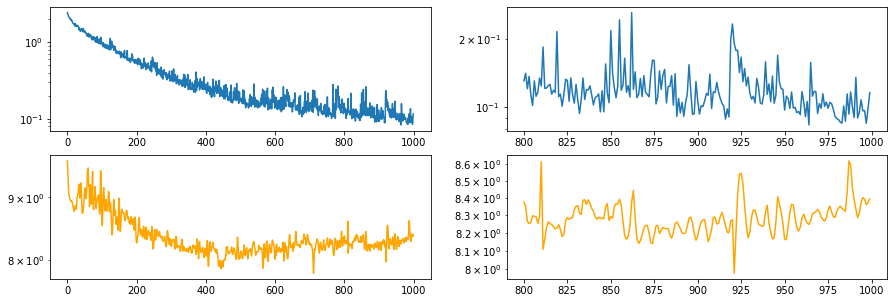

In [24]:
plot_df = history

fig,ax = plt.subplots(2,2, figsize=[15,5])
plot_df['loss'].plot(logy=True,  ax=ax[0][0])
plot_df['loss'].tail(200).plot(logy=True,  ax=ax[0][1])


plot_df['val_loss'].plot(logy=True,  ax=ax[1][0], color='orange')
plot_df['val_loss'].tail(200).plot(logy=True,  ax=ax[1][1], color='orange')

plt.show()

In [25]:
history.min()

val_loss    7.810340
loss        0.083506
dtype: float64

# Explore

## Create dataframe of results

In [26]:
# Add predictions to master dataframe
yhat = model.predict(X, verbose=0)
yhat = np.concatenate([np.zeros((n_steps,18)), 
                       yhat])
yhat = pd.DataFrame(yhat).stack()
yhat.index = learn_df.index

learn_df['predicted'] = yhat

# Remove predictions that are set as zeroes
drop_indices = list(set(learn_df.index.get_level_values('date')[:n_steps*18]))
learn_df.loc[drop_indices,'predicted'] = np.nan

In [27]:
results = learn_df[['true', 'predicted']]
results = denormalize(results, split_date, train_mean.arrivals, train_std.arrivals)

In [28]:
# Add a dataset flag for training/testing data
results['dataset'] = 'test'
results.loc[:split_date,'dataset'] = "train"

## Plot true (red) vs. predicted (blue)

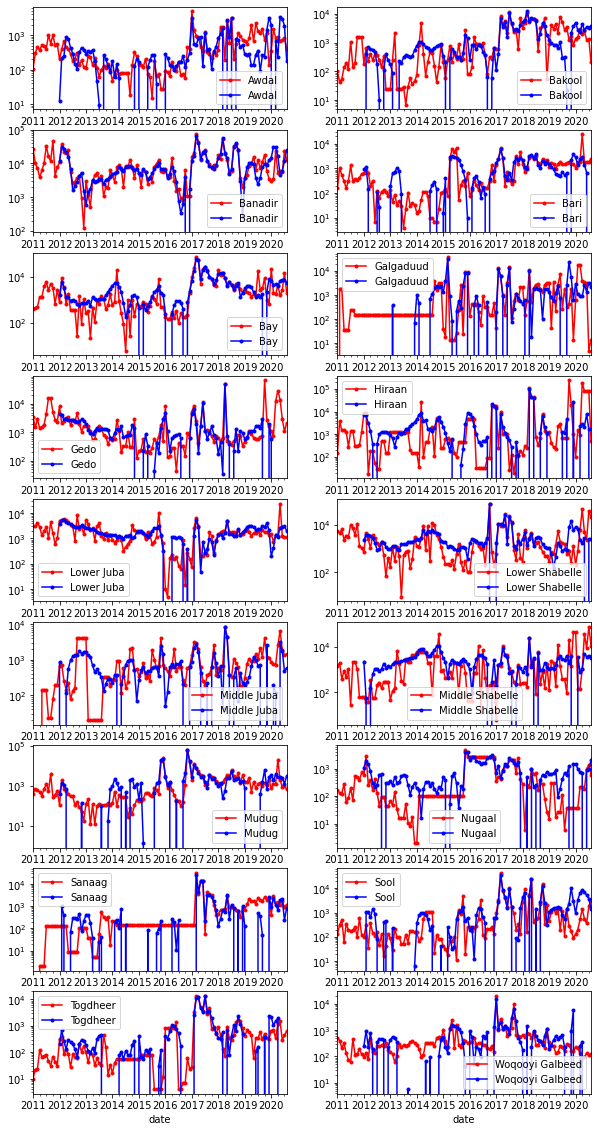

In [29]:
plot_df= results.unstack(level='region')

fig,ax = plt.subplots(9,2,figsize=[10,20])

plot_df['true'].plot(marker=".", color='red', ax=ax, subplots=True, label='True', logy=True)
plot_df['predicted'].plot(marker=".", color='blue', ax=ax, subplots=True, label='Predicted')

plt.show()

## Plot true vs. predicted for train and test

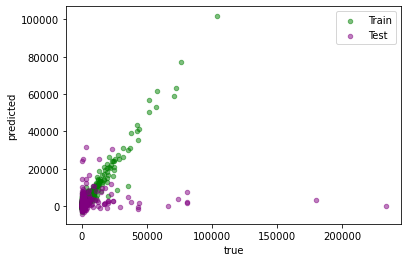

In [30]:
fig, ax = plt.subplots(1,1)
results[results.dataset=="train"].plot(x = 'true', y='predicted', kind='scatter', color='green', label='Train', ax=ax, alpha=0.5)
results[results.dataset=="test"].plot(x = 'true', y='predicted', kind='scatter', color='purple', label='Test', ax=ax, alpha=0.5)

## Evaluate

In [31]:
# RMSE
np.sqrt(((results['true']- results['predicted'])**2).mean())

8486.335620307205

In [32]:
# RMSE - training
np.sqrt(((results.loc[:split_date]['true']- results.loc[:split_date]['predicted'])**2).mean())

1585.9252762185747

In [33]:
# RMSE - test
np.sqrt(((results.loc[split_date:]['true']- results.loc[split_date:]['predicted'])**2).mean())

18618.25412593786

In [34]:
results['true'] = results['true'].round(2)

In [35]:
# Save
results.to_csv(f"ml/output_data/{fpath}/results_lstm_{n_steps}_{n_nodes}_1layer.csv")